<a href="https://colab.research.google.com/github/abhishp021/Raw-Project/blob/main/senti_analysisi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install textstat -q

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import textstat

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train = pd.read_csv('data.csv')

In [ ]:
train.head()

,textID,text,sentiment
0,2a0463352b,that`s enough! I`ll do nothing for 2 hours.,neutral
1,f358968122,I have to go clothes shopping tomorrow I hate...,negative
2,449e7733f1,i am bored. :| any idea`s of a nice site?,neutral
3,6099baf6e8,I don`t think will want to come back (guys r...,negative
4,f946da7a04,_thomas if only the drinking game was tonight....,neutral


In [ ]:
train.dropna(inplace=True)
train.shape

(18898, 3)

In [ ]:
train.pop('textID')
train.head()

,text,sentiment
0,that`s enough! I`ll do nothing for 2 hours.,neutral
1,I have to go clothes shopping tomorrow I hate...,negative
2,i am bored. :| any idea`s of a nice site?,neutral
3,I don`t think will want to come back (guys r...,negative
4,_thomas if only the drinking game was tonight....,neutral


In [ ]:
#new_train = train.copy
new_train = pd.DataFrame(train)
new_train

,text,sentiment
0,that`s enough! I`ll do nothing for 2 hours.,neutral
1,I have to go clothes shopping tomorrow I hate...,negative
2,i am bored. :| any idea`s of a nice site?,neutral
3,I don`t think will want to come back (guys r...,negative
4,_thomas if only the drinking game was tonight....,neutral
...,...,...
18894,"back at school again. almost weekend. oh wait,...",neutral
18895,Bit devastated that I lost my entire documents...,negative
18896,Last night in Australia,neutral
18897,painting,neutral


In [ ]:
new_train["num_words"] = new_train["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
new_train["num_unique_words"] = new_train["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
new_train["num_chars"] = new_train["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
new_train["num_stopwords"] = new_train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
new_train["num_punctuations"] =new_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
new_train["num_words_upper"] = new_train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
new_train["num_words_title"] = new_train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
new_train["mean_word_len"] = new_train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


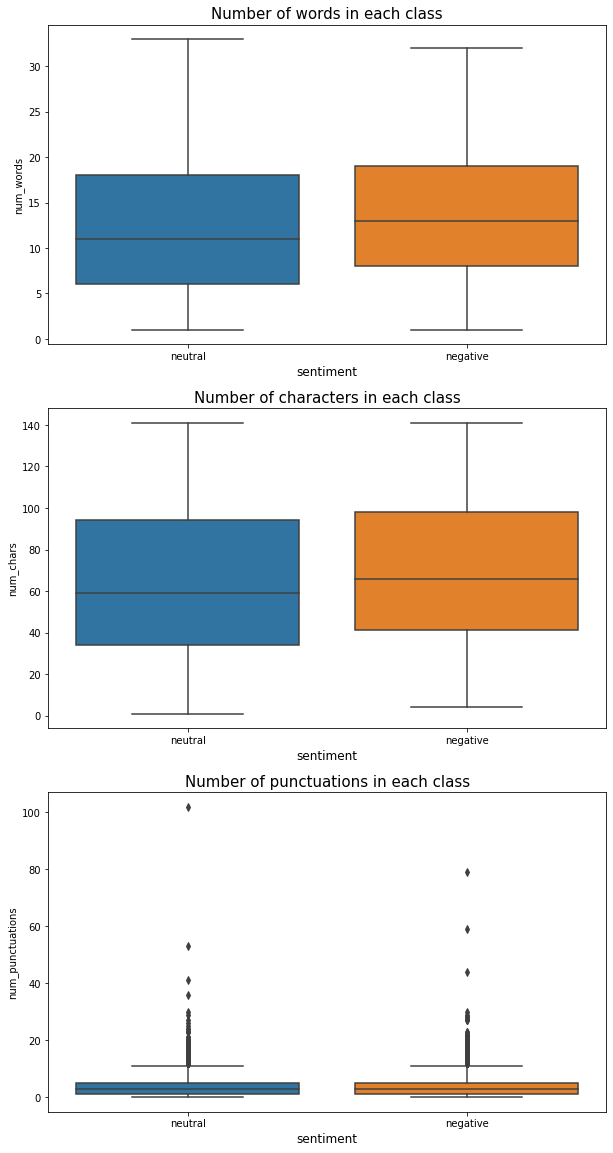

In [ ]:
f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='sentiment', y='num_words', data=new_train, ax=axes[0])
axes[0].set_xlabel('sentiment', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='sentiment', y='num_chars', data=new_train, ax=axes[1])
axes[1].set_xlabel('sentiment', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='sentiment', y='num_punctuations', data=new_train, ax=axes[2])
axes[2].set_xlabel('sentiment', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

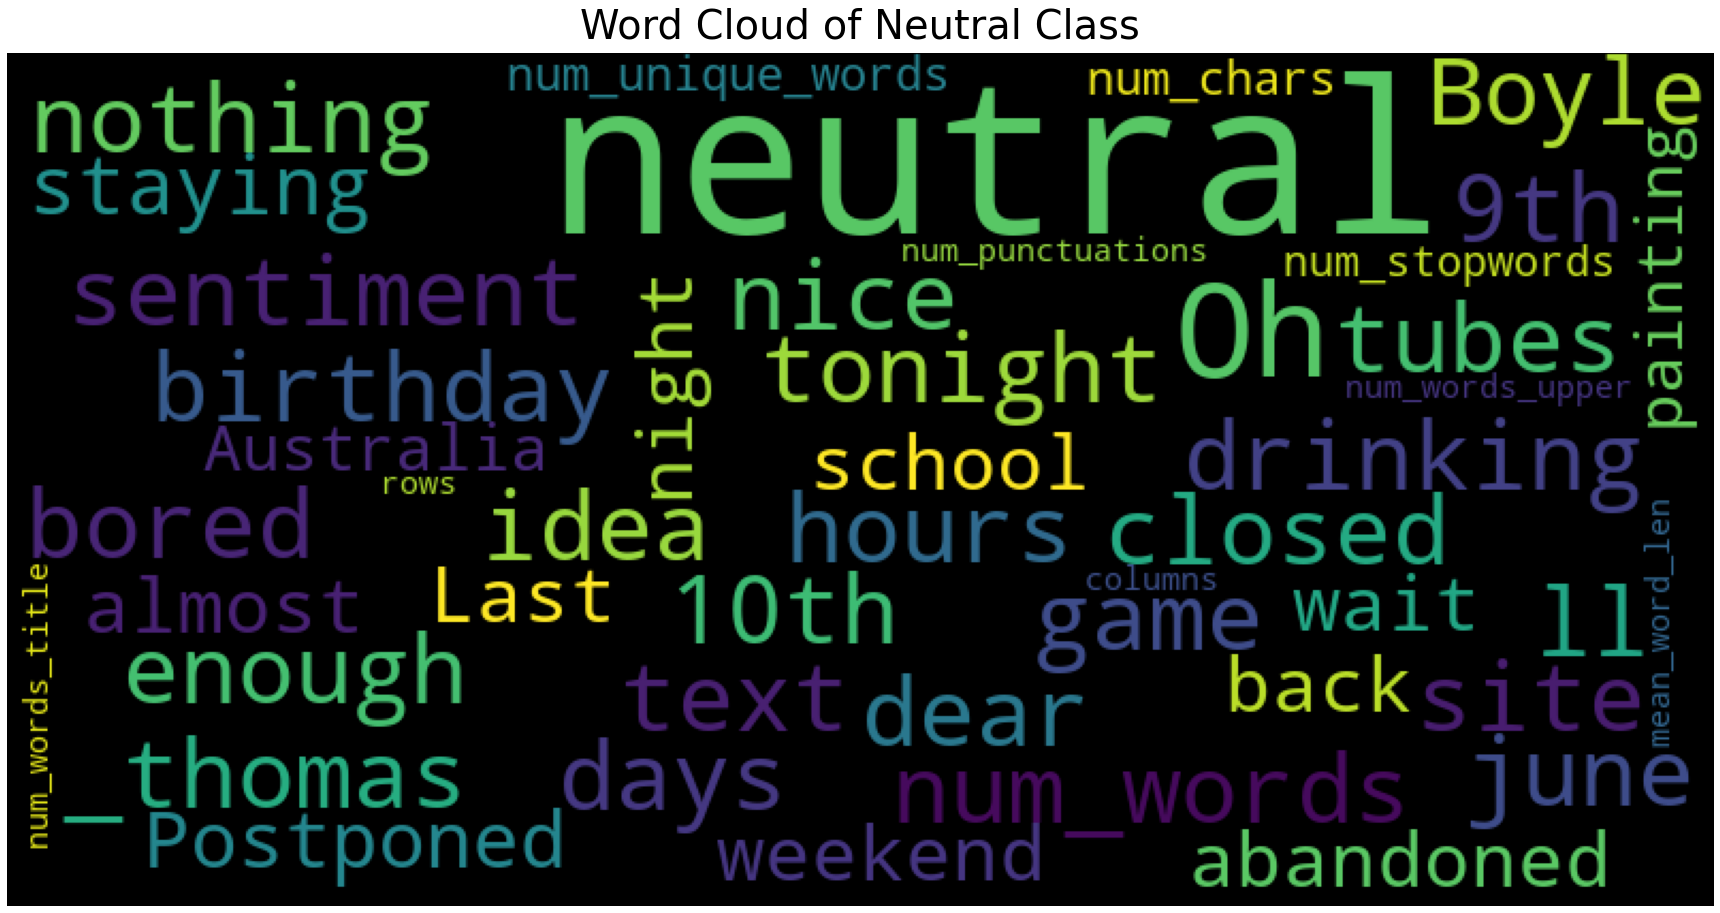

In [ ]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train[train["sentiment"]=='neutral'], title="Word Cloud of Neutral Class")


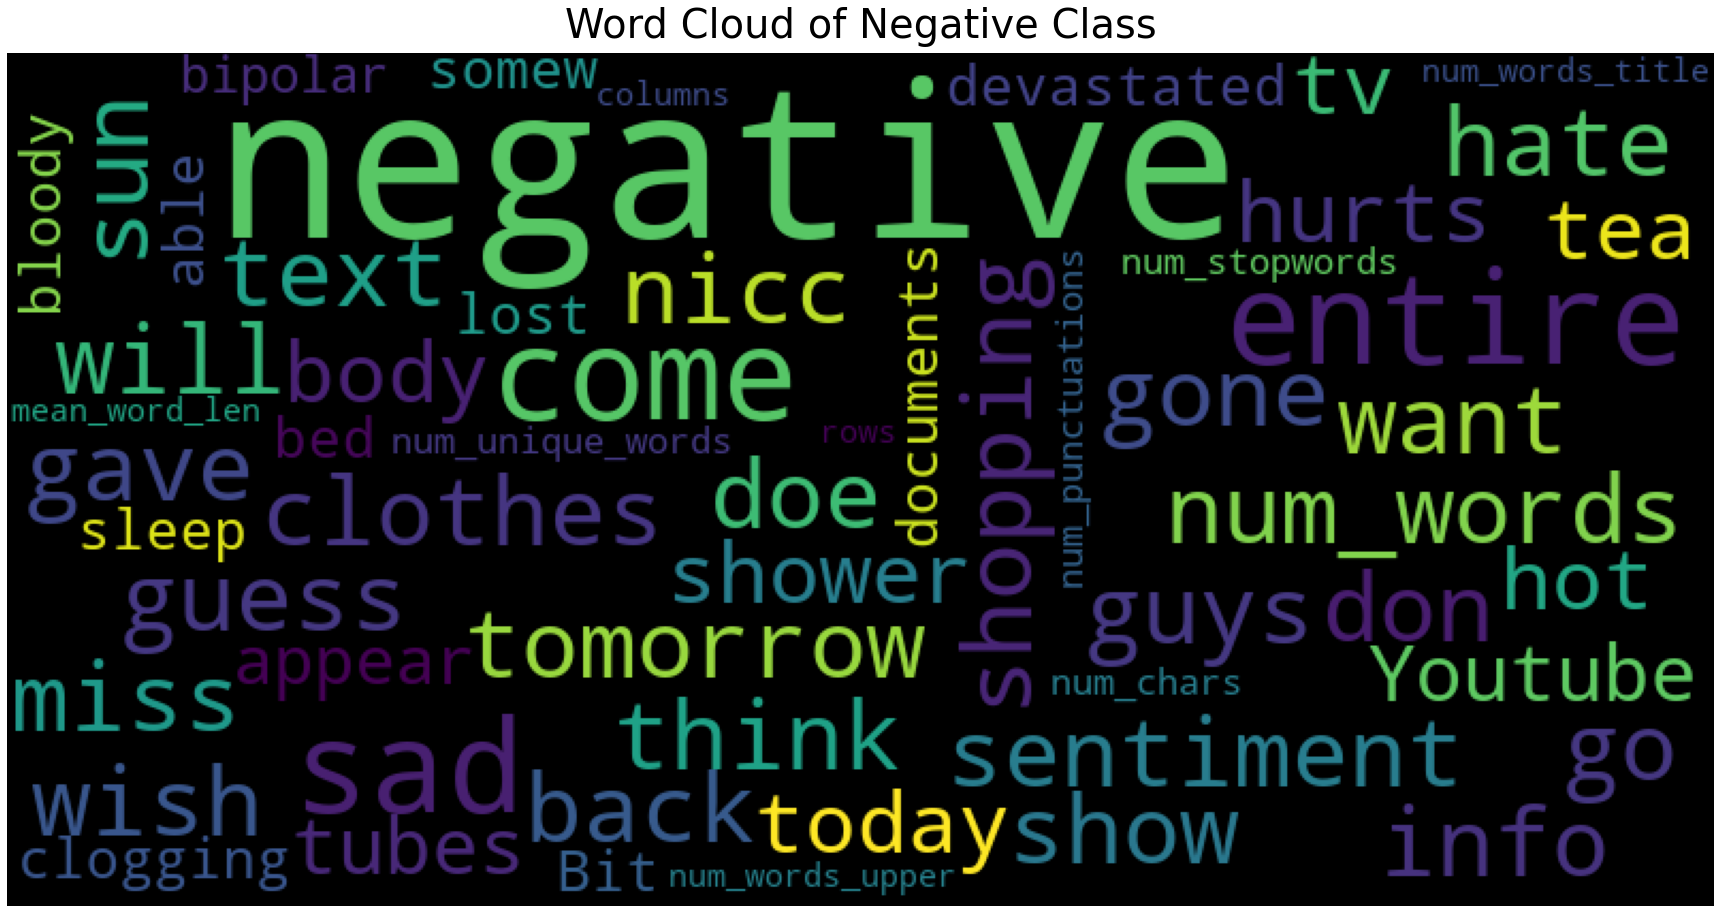

In [ ]:
plot_wordcloud(train[train["sentiment"]=='negative'], title="Word Cloud of Negative Class")

In [ ]:
le = preprocessing.LabelEncoder()

le.fit(train['sentiment'])

train['sentiment'] = le.transform(train['sentiment'])

In [ ]:
train.head()

,text,sentiment
0,that`s enough! I`ll do nothing for 2 hours.,1
1,I have to go clothes shopping tomorrow I hate...,0
2,i am bored. :| any idea`s of a nice site?,1
3,I don`t think will want to come back (guys r...,0
4,_thomas if only the drinking game was tonight....,1


In [ ]:
X=train['text']
y= train['sentiment']
print(X.shape)
print(y.shape)

(18898,)
(18898,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['sentiment'], test_size=0.20, random_state=42)

In [ ]:
y_train.head()

18745    1
14754    0
10237    0
6462     1
13572    1
Name: sentiment, dtype: int64

In [ ]:
TOKENIZER = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s):
    return TOKENIZER.sub(r' \1 ', s).split()

tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(1,4),
        tokenizer=tokenize,
        min_df=3,
        max_df=0.9,
        strip_accents='unicode',
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=True
    ).fit(pd.concat([train['text']]))
X_train = tfidf_vectorizer.transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [ ]:
model = LogisticRegression(solver='lbfgs', dual=False, class_weight='balanced', C=0.7, max_iter=1000)

model.fit(X_train, y_train)

valid_pred = model.predict_proba(X_test)

print(roc_auc_score(y_test, valid_pred,multi_class='ovr'))

ValueError: ignored

In [ ]:
clf = RandomForestClassifier(n_estimators = 1000, max_depth=2, random_state=42)

clf.fit(X_train, y_train)

valid_pred = clf.predict_proba(X_test)

print(roc_auc_score(y_test, valid_pred,multi_class='ovr'))

In [ ]:
clf = AdaBoostClassifier(n_estimators=1000, random_state=0)

clf.fit(X_train, y_train)

valid_pred = clf.predict_proba(X_test)

print(roc_auc_score(y_test, valid_pred,multi_class='ovr'))